In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### What are the five most popular commuter trips?

I defined commuter trips as trips with different starting and ending stations that take place between 7:30-9:30am or 4:30-6:30pm.

In [58]:
%%bigquery df_trips

select 
start_station_name
, end_station_name
, count(*) as trip_freq
from `bigquery-public-data.san_francisco.bikeshare_trips`
where (start_station_name <> end_station_name) and ((cast(start_date as time) between '07:30:00' and '09:30:00') or (cast(start_date as time) between '16:30:00' and '18:30:00'))
group by start_station_name, end_station_name
order by trip_freq desc
limit 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  2.53rows/s]


In [59]:
df_trips

,start_station_name,end_station_name,trip_freq
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4825
1,Embarcadero at Sansome,Steuart at Market,4303
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),4216
3,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4161
4,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),4002


### New Offer Recommendations

##### Average trip duration
Included ride time is 30 minutes for single trips and 45 minutes for membership.

In [73]:
%%bigquery
SELECT 
round(avg(duration_sec)/60,1) as avg_trip_time_min
FROM `bigquery-public-data.san_francisco.bikeshare_trips`

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.08s/rows]


,avg_trip_time_min
0,17.0


The average trip is only 17 minutes, so the average user is not hitting the limit (and being charged per additional minute) regardless of subscriber group.

##### Number of trips per subscriber type

In [72]:
%%bigquery
SELECT 
subscriber_type
, count(*) as trip_freq
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY subscriber_type

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.32rows/s]


,subscriber_type,trip_freq
0,Customer,136809
1,Subscriber,846839


The vast majority of trips are taken by subscribers. 

##### Distribution of trip duration by subscriber type

In [74]:
%%bigquery df_sub_time

SELECT 
subscriber_type,
CASE
    WHEN duration_sec/60 BETWEEN 0 AND 5 THEN '1_<= 5 Min'
    WHEN duration_sec/60 BETWEEN 5 AND 15 THEN '2_5-15 Min'
    WHEN duration_sec/60 BETWEEN 15 and 30 THEN '3_15-30 Min'
    WHEN duration_sec/60 > 30 THEN '4_>30 Min'
END AS trip_time
,count(*) as trip_freq
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
GROUP BY subscriber_type, trip_time
ORDER BY subscriber_type, trip_time

Downloading: 100%|██████████| 8/8 [00:01<00:00,  4.93rows/s]


In [75]:
df_sub_time

,subscriber_type,trip_time,trip_freq
0,Customer,1_<= 5 Min,5281
1,Customer,2_5-15 Min,48255
2,Customer,3_15-30 Min,41260
3,Customer,4_>30 Min,42013
4,Subscriber,1_<= 5 Min,174798
5,Subscriber,2_5-15 Min,597842
6,Subscriber,3_15-30 Min,68875
7,Subscriber,4_>30 Min,5324


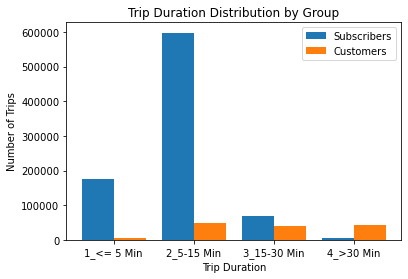

In [78]:
#Plot of trips by subscriber type and duration
X = df_sub_time.trip_time.unique()
sub_val = df_sub_time[df_sub_time['subscriber_type']=='Subscriber']['trip_freq'].values
cust_val = df_sub_time[df_sub_time['subscriber_type']=='Customer']['trip_freq'].values
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, sub_val, 0.4, label = 'Subscribers')
plt.bar(X_axis + 0.2, cust_val, 0.4, label = 'Customers')
  
plt.xticks(X_axis, X)
plt.xlabel("Trip Duration")
plt.ylabel("Number of Trips")
plt.title("Trip Duration Distribution by Group")
plt.legend()
plt.show()

Subscribers take short trips more frequently than customers. Refunding the flat unlock fee and retroactively charging based on mileage for rides that end in 10 minutes or less may incentivize non-subscribers to take more short trips.  
A higher proportion of customers are taking long trips. Offering a package of rides to use within a set time frame (ex. ten 45-minute rides to use in 90 days) with time limits beyond the single use pass may appeal to users who don't bike frequently enough to want a membership but exceed the 30 minute limit when they do ride.

##### What are the most common customer trips and how long do they last?

In [79]:
%%bigquery cust_trips
SELECT 
subscriber_type
,start_station_name
,end_station_name
, count(*) as trip_freq
, round(avg(duration_sec/60),1) as trip_duration_min
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE subscriber_type = 'Customer'
GROUP BY start_station_name, end_station_name, subscriber_type
ORDER BY trip_freq 
DESC LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.18rows/s]


In [80]:
cust_trips

,subscriber_type,start_station_name,end_station_name,trip_freq,trip_duration_min
0,Customer,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,3667,38.1
1,Customer,Embarcadero at Sansome,Embarcadero at Sansome,2545,78.7
2,Customer,Harry Bridges Plaza (Ferry Building),Harry Bridges Plaza (Ferry Building),2004,113.4


Two of the most common customer trips end at their origin station and last well beyond the 30 minute window. Offering a higher flat unlock fee coupled with a mileage-based pricing option may increase ridership among customers that use the bikes more for leisure than transport. 